### Integrate and Fire Model

This notebook want to implement the Integrated and Fire models and also Adaptation Dynamics.

1) Perfect Integrate & Fire (I&F).

$\frac{dU}{dt} = \frac{I(t)}{C} $

2) Leaky I&F. For improve the decay of the neuron

$C \frac{dU}{dt} = -g_L\cdot (U-U_R) + I(t) $

3) Exponential I&F. For improve the firing of the neuron

$C \frac{dU}{dt} = -g_L\cdot (U-U_R) + \Delta_T \cdot e^{\frac{U - U_{thr}}{\Delta_T}}  + I(t) $

4) Refractory EI&F. For improve the dynamics after neuron fires. 

$C \frac{dU}{dt} = -g_L\cdot (U-U_R) + \Delta_T \cdot e^{\frac{U - U_{thr}}{\Delta_T}}  + I(t) $

The reset $U_R$ = $U_R$ + $U_{Refractory}$ for small amount of time.

For all these models we will implement the Euler Forward method. In which,
1) Calculate in a discrete way $\frac{dU}{dt} = F(u)$
2) We will update each step in time by the rule $ u[t + \Delta_t] = u[i-1] + \Delta_t \cdot F(u)$

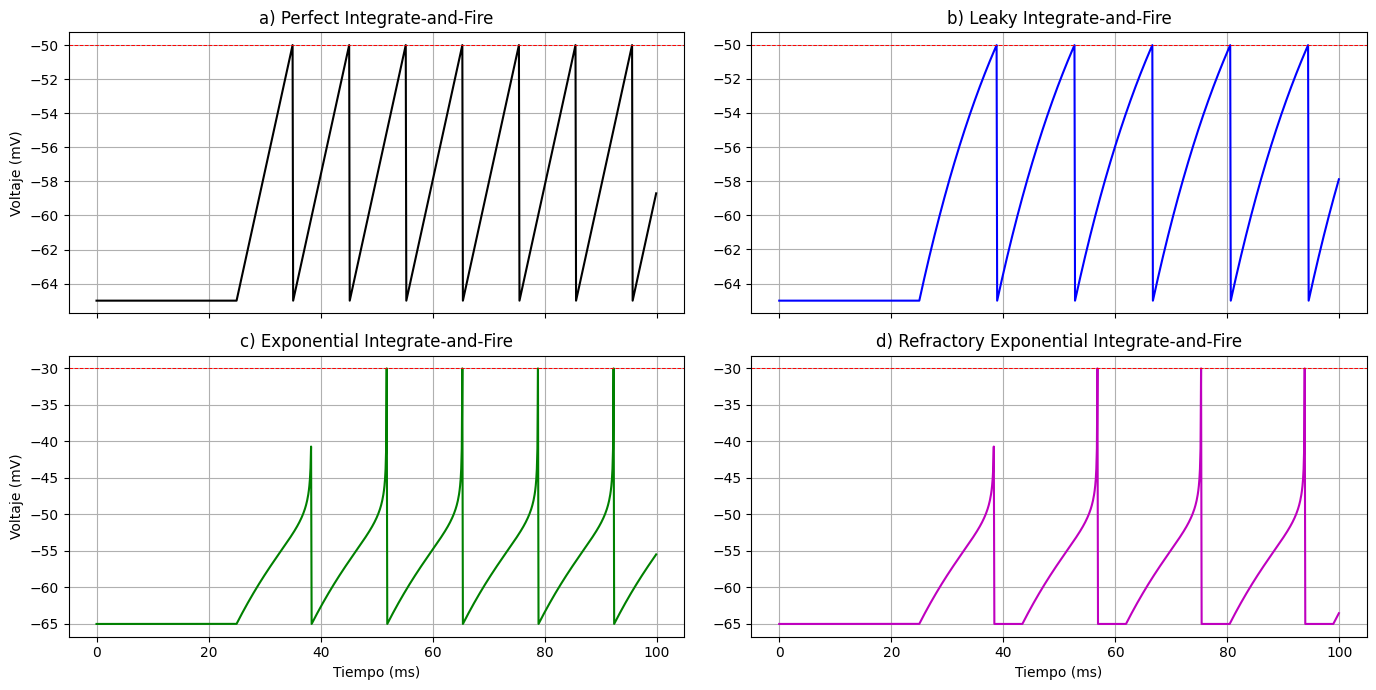

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ================================================
#  1) FUNCIÓN ÚNICA SIMULTÁNEA
# ================================================
def simulate_all_if_models(time, I,
                           C=1.0,
                           u_rest=-65.0, theta_if=-50.0,
                           tau_m=20.0, Delta_T=2.0, U_th=-55.0, V_peak=-30.0,
                           tau_ref=5.0):
    """
    Simula los cuatro modelos de Integrate-and-Fire a la vez,
    actualizando en cada paso de tiempo:
      - Perfect IF
      - Leaky IF (LIF)
      - Exponential IF (EIF)
      - Refractory Exponential IF (R-EIF)

    Parámetros:
    - time: array de instantes de simulación (ms).
    - I:    array de corriente de entrada en cada instante (mismos índices que time).
    - C: capacitancia de membrana (unidades arbitrarias).
    - u_rest: potencial de reposo (mV).
    - theta_if: umbral para IF y LIF (mV).
    - tau_m: constante de tiempo de membrana para LIF/EIF (ms).
    - Delta_T: slope factor para EIF (mV).
    - U_th: umbral “suave” para EIF (mV).
    - V_peak: umbral de “peak” para detectar spike en EIF/REIF (mV).
    - tau_ref: periodo refractario absoluto para R-EIF (ms).

    Retorna:
    - u_if, u_lif, u_eif, u_reif: arrays con el voltaje en cada instante para cada modelo.
    - spikes_if, spikes_lif, spikes_eif, spikes_reif: listas de tiempos de spike.
    """
    dt = time[1] - time[0]
    n_steps = len(time)

    # --- Prealocar voltajes y listas de spikes ---
    u_if   = np.full(n_steps, u_rest)
    u_lif  = np.full(n_steps, u_rest)
    u_eif  = np.full(n_steps, u_rest)
    u_reif = np.full(n_steps, u_rest)

    spikes_if   = []
    spikes_lif  = []
    spikes_eif  = []
    spikes_reif = []

    # --- Parámetros derivados ---
    g_L = C / tau_m                     # conductancia de fuga para LIF/EIF/R-EIF
    ref_steps = int(np.round(tau_ref / dt))  # número de pasos de dt que dura el refractario

    # En R-EIF necesitamos llevar la cuenta del último spike (en iteraciones)
    last_spike_idx_reif = -ref_steps - 1

    # ===================================================
    #  Bucle temporal único: en cada paso actualizamos
    #       IF, LIF, EIF y R‐EIF al mismo tiempo.
    # ===================================================
    for i in range(1, n_steps):
        # --- Corriente en este instante (para Euler usar I[i-1]) ---
        I_prev = I[i-1]

        # ===============================
        #  (1) Perfect Integrate-and-Fire
        # ===============================
        du_if = I_prev / C
        u_if[i] = u_if[i-1] + dt * du_if
        if u_if[i] >= theta_if:
            u_if[i] = u_rest
            spikes_if.append(time[i])

        # ===============================
        #  (2) Leaky Integrate-and-Fire
        # ===============================
        du_lif = (-(u_lif[i-1] - u_rest) * g_L + I_prev) / C
        u_lif[i] = u_lif[i-1] + dt * du_lif
        if u_lif[i] >= theta_if:
            u_lif[i] = u_rest
            spikes_lif.append(time[i])

        # ============================================
        #  (3) Exponential Integrate-and-Fire (EIF)
        # ============================================
        exp_term_eif = g_L * Delta_T * np.exp((u_eif[i-1] - U_th) / Delta_T)
        du_eif = (-(u_eif[i-1] - u_rest) * g_L + exp_term_eif + I_prev) / C
        u_eif[i] = u_eif[i-1] + dt * du_eif
        if u_eif[i] >= V_peak:
            u_eif[i] = u_rest
            spikes_eif.append(time[i])

        # =====================================================
        #  (4) Refractory Exponential Integrate-and-Fire (R‐EIF)
        # =====================================================
        # (a) Si estamos dentro del refractario absoluto:
        if i - last_spike_idx_reif <= ref_steps:
            u_reif[i] = u_rest
            U_th_active = U_th + 10.0
        else:
            U_th_active = U_th

        # (b) Si ya salimos del refractario, integramos con Euler:
        if i - last_spike_idx_reif > ref_steps:
            exp_term_reif = g_L * Delta_T * np.exp((u_reif[i-1] - U_th_active) / Delta_T)
            du_reif = (-(u_reif[i-1] - u_rest) * g_L + exp_term_reif + I_prev) / C
            u_reif[i] = u_reif[i-1] + dt * du_reif
            if u_reif[i] >= V_peak:
                u_reif[i] = u_rest
                spikes_reif.append(time[i])
                last_spike_idx_reif = i

    # --- Devolver resultados ---
    return u_if, u_lif, u_eif, u_reif, spikes_if, spikes_lif, spikes_eif, spikes_reif


# ======================================
#  2) CONFIGURAR Y LLAMAR A LA FUNCIÓN
# ======================================

# 2.1 Vector de tiempo y corriente de entrada
T = 100.0
dt = 0.1
time = np.arange(0, T, dt)

# Creamos un escalón de corriente que se activa a 100 ms
I = np.zeros_like(time)
I[time >= 25] = 1.5   # en unidades arbitrarias (p.ej. nA)

# 2.2 Umbrales globales para plot
theta_if = -50.0   # umbral común para IF/LIF
V_peak   = -30.0   # umbral “peak” para EIF/R‐EIF

# 2.3 Simular simultáneamente
u_if, u_lif, u_eif, u_reif, spikes_if, spikes_lif, spikes_eif, spikes_reif = \
    simulate_all_if_models(time, I,
                           C=1.0,
                           u_rest=-65.0, theta_if=theta_if,
                           tau_m=20.0, Delta_T=2.0, U_th=-55.0, V_peak=V_peak,
                           tau_ref=5.0)

# ======================================
#  3) GRAFICAR RESULTADOS EN 2x2
# ======================================
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)

# (a) Perfect Integrate-and-Fire
ax = axes[0, 0]
ax.plot(time, u_if, 'k')
ax.axhline(theta_if, color='r', linestyle='--', linewidth=0.7)
ax.set_ylabel('Voltaje (mV)')
ax.set_title('a) Perfect Integrate-and-Fire')
ax.grid(True)

# (b) Leaky Integrate-and-Fire
ax = axes[0, 1]
ax.plot(time, u_lif, 'b')
ax.axhline(theta_if, color='r', linestyle='--', linewidth=0.7)
ax.set_title('b) Leaky Integrate-and-Fire')
ax.grid(True)

# (c) Exponential Integrate-and-Fire
ax = axes[1, 0]
ax.plot(time, u_eif, 'g')
ax.axhline(V_peak, color='r', linestyle='--', linewidth=0.7)
ax.set_ylabel('Voltaje (mV)')
ax.set_xlabel('Tiempo (ms)')
ax.set_title('c) Exponential Integrate-and-Fire')
ax.grid(True)

# (d) Refractory Exponential Integrate-and-Fire
ax = axes[1, 1]
ax.plot(time, u_reif, 'm')
ax.axhline(V_peak, color='r', linestyle='--', linewidth=0.7)
ax.set_xlabel('Tiempo (ms)')
ax.set_title('d) Refractory Exponential Integrate-and-Fire')
ax.grid(True)

plt.tight_layout()
plt.show()


### Adaptative Integrated & Fire Model.
This model was relevant to pass from 1D diff equations to 2D and improve the spiking patterns. Notably, it offers an idea of intrisic mechanism behind neurons. We use Euler forward method,

$$
\begin{aligned}
C \frac{du}{dt} &= -g_L (u - E_L) + g_L \Delta_T e^{\frac{u - V_T}{\Delta_T}} - w + I(t) \\
\tau_w \frac{dw}{dt} &= -w + a (u - E_L) \\
\text{if } u &\geq V_{\text{peak}}, &\text{ then }
\begin{cases}
u \rightarrow u_{\text{reset}} \\
w \rightarrow w + b
\end{cases}
\end{aligned}
$$





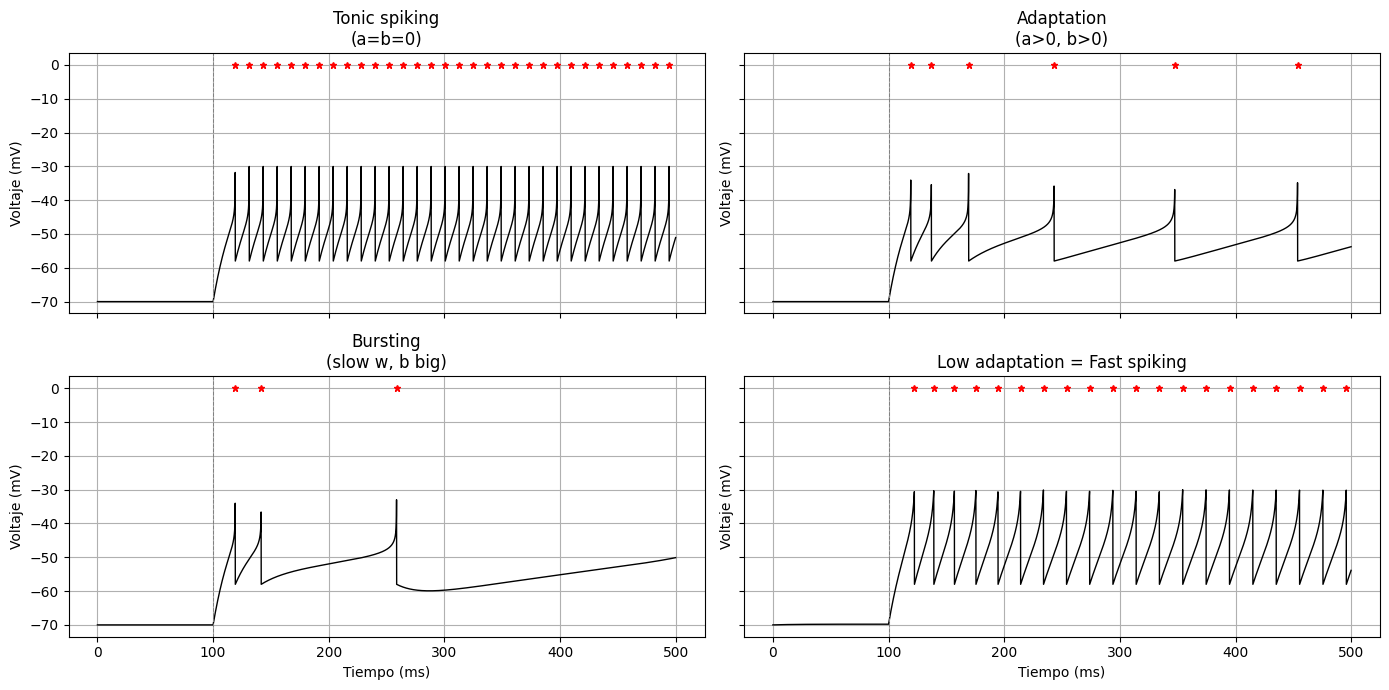

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_adex(time, I, params):
    """
    Simula el modelo AdEx

    Parámetros:
        time  : vector de tiempos (ms)
        I     : vector de corriente de entrada, mismo largo que time
        params: diccionario con claves:
                C, gL, EL, DeltaT, VT, V_peak, u_reset,
                tau_w, a, b
    Retorna:
        u, w, spike_times
    """
    # Extraer parámetros
    C       = params['C']
    gL      = params['gL']
    EL      = params['EL']
    DeltaT  = params['DeltaT']
    VT      = params['VT']
    V_peak  = params['V_peak']
    u_reset = params['u_reset']

    tau_w   = params['tau_w']
    a       = params['a']
    b       = params['b']

    dt = time[1] - time[0]
    n_steps = len(time)

    # Prealocar variables
    u = np.full(n_steps, EL)   # comenzamos en potencial de reposo EL
    w = np.zeros(n_steps)      # variable de adaptación comienza en 0
    spike_times = []

    for i in range(1, n_steps):
        # Corriente de entrada en el paso previo
        I_prev = I[i-1]

        # 1) Ecuación de u(t) (Euler hacia adelante)
        exp_term = gL * DeltaT * np.exp((u[i-1] - VT) / DeltaT)
        du = ( -gL * (u[i-1] - EL) + exp_term - w[i-1] + I_prev ) / C
        u_temp = u[i-1] + dt * du

        # 2) Ecuación de w(t) (Euler hacia adelante)
        dw = (-w[i-1] + a * (u[i-1] - EL)) / tau_w
        w_temp = w[i-1] + dt * dw

        # 3) Check de disparo
        if u_temp >= V_peak:
            # Spike: reiniciamos u y aumentamos w
            u[i] = u_reset
            w[i] = w_temp + b
            spike_times.append(time[i])
        else:
            u[i] = u_temp
            w[i] = w_temp

    return u, w, spike_times

# ========================================
#  Parámetros globales y vector de tiempo
# ========================================

T  = 500.0            # tiempo total (ms)
dt = 0.1              # paso de integración (ms)
time = np.arange(0, T, dt)

# Corriente de entrada: escalón de 100 a 500 ms
I = np.zeros_like(time)
I[time >= 100] = 400.0  # p.ej. pA o unidades arbitrarias

# Parámetros “fijos” para AdEx
base_params = {
    'C'      : 200.0,   # pF
    'gL'     : 10.0,    # nS   -> tau_m = C/gL = 20 ms
    'EL'     : -70.0,   # mV
    'DeltaT' : 2.0,     # mV
    'VT'     : -50.0,   # mV
    'V_peak' : -30.0,   # mV
    'u_reset': -58.0    # mV
}

# ===========================================
#  4 conjuntos de parámetros para los 4 patrones
# ===========================================

param_sets = []

# 1) Tonic spiking (sin adaptación: a=b=0)
p1 = base_params.copy()
p1.update({
    'tau_w' : 100.0,  # aunque no importe, fijamos un valor grande
    'a'     : 0.0,
    'b'     : 0.0
})
param_sets.append(('Tonic spiking\n(a=b=0)', p1))

# 2) Spike-frequency adaptation (a>0, b>0)
p2 = base_params.copy()
p2.update({
    'tau_w' : 200.0,
    'a'     : 4.0,    # mV‐1
    'b'     : 80.0    # pA
})
param_sets.append(('Adaptation\n(a>0, b>0)', p2))

# 3) Bursting (adaptación más lenta pero con b grande)
p3 = base_params.copy()
p3.update({
    'tau_w' : 500.0,
    'a'     : 2.0,
    'b'     : 120.0
})
param_sets.append(('Bursting\n(slow w, b big)', p3))

# 4) Fast spiking (DeltaT alto + baja adaptación)
p4 = base_params.copy()
p4.update({
    'DeltaT' : 6.0,   # fase de ascenso más rápida
    'tau_w'  : 50.0,  # adaptación áspera/suave
    'a'      : 1.0,
    'b'      : 20.0
})
param_sets.append(('Low adaptation = Fast spiking', p4))

# ========================================
#  Simular cada patrón y almacenar resultados
# ========================================

results = []
for title, params in param_sets:
    u, w, spikes = simulate_adex(time, I, params)
    results.append((title, u, w, spikes))

# ========================================
#  Graficar los 4 paneles (2×2)
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (title, u, w, spikes) in enumerate(results):
    ax = axes[idx]
    ax.plot(time, u, 'k', linewidth=1)
    ax.set_title(title)
    ax.axvline(100, color='gray', linestyle='--', linewidth=0.7)  # inicio del escalón de I
    ax.set_ylabel('Voltaje (mV)')
    ax.grid(True)

    # Marcar spikes con un marcador
    for t_spike in spikes:
        ax.plot(t_spike, 0, 'r*', markersize=5)  # estrella roja en y=0 (solo para visualizar)

axes[-2].set_xlabel('Tiempo (ms)')
axes[-1].set_xlabel('Tiempo (ms)')

plt.tight_layout()
plt.show()
